# Exercise - Estimating Mean and Standard Deviation of Normal Distribution with Pyro

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements) 
  * [Knowledge](#Knowledge)
  * [Modules](#Python-Modules)
* [Data](#Data)
* [Working with Pyro](#Working-with-Pyro)
 * [The Model](#The-Model)
 * [The Guide](#The-Guide)
 * [Stochastic Variational Inference - SVI](#Stochastic-Variational-Inference---SVI)
* [Exercise - Estimate Tau (and Mean)](#Exercise---Estimate-Precision-and-Mean)
* [Literature](#Literature)
* [Licenses](#Licenses)

## Introduction

"Pyro is a universal probabilistic programming language (PPL) written in Python and supported by PyTorch on the backend. Pyro enables flexible and expressive deep probabilistic modeling, unifying the best of modern deep learning and Bayesian modeling." ([https://pyro.ai/](https://pyro.ai/)).

In this exercise you will use Pyro to estimate the parameters of a normal distribution.


In order to detect errors in your own code, execute the notebook cells containing `assert` or `assert_almost_equal`.

## Requirements

### Knowledge

#### Theory

All *Pyro*-exercises are intended as part of the course [Bayesian Learning](https://dev.deep-teaching.org/courses/bayesian-learning). Therefore work through the course up to and including chapter [Probabilistic Programming](https://dev.deep-teaching.org/courses/bayesian-learning#probabilistic-programming).


#### Pyro

* The official Tutorial:
    * https://pyro.ai/examples/intro_part_i.html
    * https://pyro.ai/examples/intro_part_ii.html
    * https://pyro.ai/examples/svi_part_i.html

### Python Modules

In [1]:
import numpy as np

import scipy.stats
from scipy.stats import norm

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

%matplotlib inline

In [2]:
import torch
from torch.distributions import constraints

import pyro
import pyro.infer
import pyro.optim as optim
import pyro.distributions as dist

## Data

Our observed data comes from a normal distribution:

Data:
$$
 X \sim \mathcal N(\mu, \frac{1}{\tau})
$$


Probability Density Function:
$$
p(X \mid \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau (X-\mu)^2 }{2} \right)
$$

with  
- $\mu$: mean
- $\sigma^2$: variance
- $\tau =\frac{1}{\sigma^2}$ : precision

In [3]:
dtype=torch.float32

In [4]:
torch.manual_seed(101)
pyro.set_rng_seed(101)
np.random.seed(12);

In [5]:
# generate observed data
N = 10
mu_ = 10.
sigma_= 2.
X = np.random.normal(mu_, sigma_, N)
X = np.array(X, dtype=np.float32)

In [7]:
X

array([10.9459715,  8.637148 , 10.484879 ,  6.598529 , 11.506286 ,
        6.9305573, 10.010254 ,  9.759544 ,  8.386036 , 15.743639 ],
      dtype=float32)

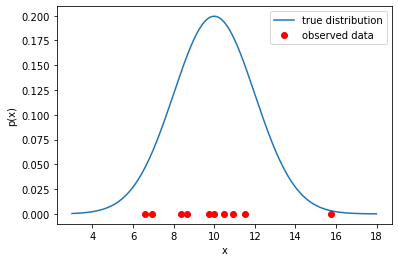

In [8]:
x = np.arange(3,18,0.01)
p_x = scipy.stats.norm.pdf(x, loc=mu_, scale=sigma_)
plt.plot(x, p_x, label="true distribution")
plt.plot(X, np.zeros_like(X), "ro", label="observed data")
plt.title("")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend();

## Working with Pyro

### The Model

We use the generated data $X \sim \mathcal N(\mu, 1/\tau)$ as observed data.

For modeling the data we design the following model with pyro:

- We use a Uniform prior for the mean $\mu$:
    * $\mu \sim \text{Uniform}(-25,25)$
- We use a constant $\tau=1/4$ for the precision.
    * Note: This has to be a `torch.tensor` object
    
So, we have only one (scalar) parameter $\theta=\{\mu\}$ in the model.

In [9]:
def model(X):
    # Prior
    mu = pyro.sample("mu", dist.Uniform(torch.tensor(-25.), torch.tensor(+25.))) 
    tau = torch.tensor(1/4)


    # pyro plate mark the samples as conditional independet
    with pyro.plate("observed_data", size=len(X)):
        sample = pyro.sample("gaussian_data", dist.Normal(mu, 1/torch.sqrt(tau)), obs=X)
    
    return sample

### The Guide

Next we implement the "Guide", which we will later on use in conjuction with our model for stochastic variational inference (`pyro.infer.SVI()`).

We use as variational distribution also a Gaussian.
$$
\mu \sim \mathcal N(mean_{\mu}, scale_{\mu}^2)
$$

In [10]:
### same (function) arguments for guide and model !
def guide(X):
    mean_loc = torch.randn((1)) 
    # note that we initialize the scale to be pretty narrow
    mean_scale = torch.tensor(0.001)
    
    # mu_loc and mu_scale are the (variational) parameters
    # they will be learned by SVI from the data
    
    mu_loc = pyro.param("guide_mu_mean", mean_loc)
    
    # the scale must be positive.
    mu_scale = pyro.param("guide_mu_scale", mean_scale, constraint=constraints.positive)

    # note the same name "mu" here as in our model
    mu = pyro.sample("mu", dist.Normal(mu_loc, mu_scale)) 


### Stochastic Variational Inference - SVI

Now we optimize the variational parameters, i.e. find values for $mean_{\mu}$(`guide_mu_loc`) , $scale_{\mu}$(`guide_mu_scale`).

In [11]:
pyro.clear_param_store()

adam_params = {"lr": 0.003, "betas": (0.95, 0.999)}
optimizer = optim.Adam(adam_params)

svi = pyro.infer.SVI(model=model,
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

In [12]:
### to keep track of our loss history
losses = []

### convert observed data to a torch tensor object
X_ = torch.tensor(X, dtype=dtype)

### training / inference
for t in range(10000):
    ### svi.step takes same parameters as inpust as our defined model(X) and guide(X) function
    loss = svi.step(X_)
    losses.append(loss)
    ### for monitoring
    if t%100==0:
        print (t, "\t", loss)

0 	 192.7898645401001
100 	 182.77566051483154
200 	 175.62650108337402
300 	 167.52554512023926
400 	 160.4677028656006
500 	 152.7523307800293
600 	 145.86118698120117
700 	 138.8842272758484
800 	 132.40819215774536
900 	 125.13015508651733
1000 	 120.28953409194946
1100 	 114.50648021697998
1200 	 109.0264321565628
1300 	 104.05447161197662
1400 	 98.44436323642731
1500 	 94.8081842660904
1600 	 88.7485808134079
1700 	 82.15620362758636
1800 	 81.87902522087097
1900 	 79.11943554878235
2000 	 75.53384268283844
2100 	 66.19532096385956
2200 	 68.04433608055115
2300 	 66.57482993602753
2400 	 62.50554394721985
2500 	 58.092737913131714
2600 	 50.86673945188522
2700 	 50.28860080242157
2800 	 50.554264426231384
2900 	 51.21060395240784
3000 	 52.01752185821533
3100 	 46.69825541973114
3200 	 46.012785851955414
3300 	 36.88210213184357
3400 	 39.41662901639938
3500 	 38.12995171546936
3600 	 37.32512640953064
3700 	 36.20981675386429
3800 	 27.626056909561157
3900 	 33.031264930963516


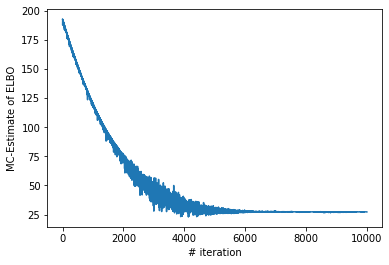

In [13]:
### Let us plot the costs / iteration curve

plt.xlabel("# iteration")
plt.ylabel("MC-Estimate of ELBO")
plt.plot(range(len(losses)), losses)

In [14]:
# Adjust the strings according to your names for
# the parameters "mu_mean", etc...
mu_mean_param = pyro.param("guide_mu_mean")
mu_scale_param = pyro.param("guide_mu_scale")
mu_mean_param, mu_scale_param

(tensor([9.9143], requires_grad=True), tensor(0.6270, grad_fn=<AddBackward0>))

true mu:  10.0


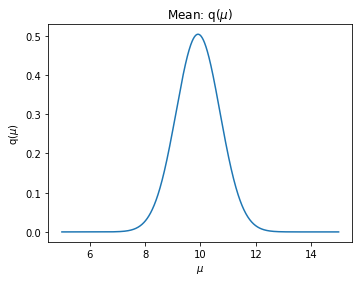

In [15]:
plt.figure(figsize=(12,4))

mu_mean = mu_mean_param.detach().numpy()
mu_scale = mu_scale_param.detach().numpy()

x = np.arange(5,15,0.01)
p_mu = scipy.stats.norm.pdf(x, loc=mu_mean, scale=np.sqrt(mu_scale))
ax = plt.subplot(121)
ax.plot(x, p_mu)
ax.set_xlabel("$\mu$")
ax.set_ylabel("q($\mu$)")
ax.set_title("Mean: q($\\mu$)")
print("true mu: ", mu_)

## Exercise - Estimate Precision and Mean

**Task:**

Extend the model and the guide by using additionally a variational distribution for $\tau$:
- Use a Uniform distribution for the proir of $\tau$: $\tau \sim \text{Uniform}(0.01, 2)$
- Use a Gamma distribution as variational distribution for $\tau$: $\text{Gamma}(a, b)$
- Additionally, find the parameters $a$ (`guide_tau_concentration`), $b$ (`guide_tau_rate`) (and $mean_{\mu}$ `guide_mu_mean`, $scale_{\mu}$ `guide_mu_scale`) via optimization.


If your extensions are correct, executing the cells at the end should plot figures similar to these:

<img src="https://gitlab.com/deep.TEACHING/educational-materials/raw/master/media/klaus/exercise-mean-field-approximation-simple-gaussian-plot.png" width="768" alt="internet connection needed">

#### Gamma Function

Use the plot of a gamma function to find appropriate values for the variational parameters.

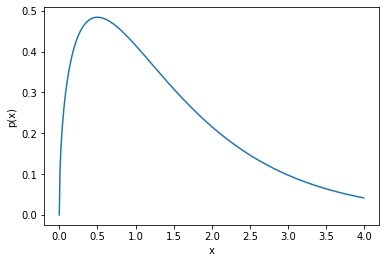

In [16]:
concentration = 1.5
rate = 1.

x = np.arange(0,4,0.01)
p_tau = scipy.stats.gamma.pdf(x, a=concentration, scale=1/rate)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.plot(x, p_tau)

In [17]:
# Note that dist.Gamma has a different parameter signature: __init__(self, concentration, rate, validate_args=None)
# see:
#help(dist.Gamma)

In [18]:
def model_with_tau(X):
    
    ######################
    ### Your Code here ###
    ######################

    
    return

In [46]:
def guide_with_tau(X):
    
    ######################
    ### Your Code here ###
    ######################

    
    return

In [48]:
### Initilize pyro.infer.SVI object

######################
### Your Code here ###
######################

In [50]:
### Training

######################
### Your Code here ###
######################

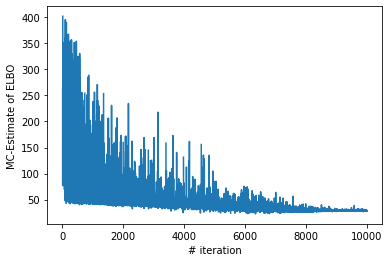

In [52]:
### Let us plot the costs / iteration curve

plt.xlabel("# iteration")
plt.ylabel("MC-Estimate of ELBO")
plt.plot(range(len(losses)), losses)

In [33]:
# Adjust the strings according to your names for
# the parameters "mu_mean", etc...
mu_mean_param = pyro.param("guide_mu_mean")
mu_scale_param = pyro.param("guide_mu_scale")
mu_mean_param, mu_scale_param

(tensor([9.6985], requires_grad=True), tensor(0.8747, grad_fn=<AddBackward0>))

In [34]:
# Adjust the strings according to your names for
# the parameters "mu_mean", etc...
tau_concentration_param = pyro.param("guide_tau_concentration")
tau_rate_param = pyro.param("guide_tau_rate")
tau_concentration_param, tau_rate_param

(tensor(3.2261, grad_fn=<AddBackward0>),
 tensor(17.3125, grad_fn=<AddBackward0>))

true mu:  10.0
true tau:  0.25


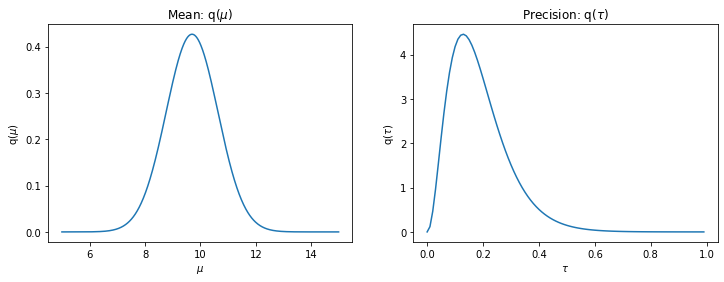

In [35]:
plt.figure(figsize=(12,4))

mu_mean = mu_mean_param.detach().numpy()
mu_scale = mu_scale_param.detach().numpy()

x = np.arange(5,15,0.01)
p_mu = scipy.stats.norm.pdf(x, loc=mu_mean, scale=np.sqrt(mu_scale))
ax = plt.subplot(121)
ax.plot(x, p_mu)
ax.set_xlabel("$\mu$")
ax.set_ylabel("q($\mu$)")
ax.set_title("Mean: q($\\mu$)")
print("true mu: ", mu_)

tau_concentration =tau_concentration_param.detach().numpy()
tau_rate = tau_rate_param.detach().numpy()

x = np.arange(0,1,0.01)
p_tau = scipy.stats.gamma.pdf(x, a=tau_concentration, scale=1/tau_rate)
ax = plt.subplot(122)
ax.plot(x, p_tau)
ax.set_xlabel("$\\tau$")
ax.set_ylabel("q($\\tau$)")
ax.set_title("Precision: q($\\tau$)")
print("true tau: ", 1/sigma_**2)


## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Exercise - Pyro Simple Gaussian <br/>
by Christian Herta<br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2019 Christian Herta

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.